# Bibliotecas

Nesta seção, vamos instalar e importar todas as bibliotecas utilizadas para o trabalho.

- [osmnx](https://osmnx.readthedocs.io/en/stable/)
- [geopandas](https://geopandas.org/en/stable/),
- [pandas](https://pandas.pydata.org/),
- [seaborn](https://seaborn.pydata.org/),
- [folium](https://python-visualization.github.io/folium/latest/),
- [matplotlib](https://matplotlib.org/),
- [shapely](https://shapely.readthedocs.io/en/stable/manual.html) e
- [networkx](https://networkx.org/)

1. Instalar bibliotecas com `pip`

In [ ]:
!pip install osmnx
!pip install geopandas
!pip install pandas
!pip install seaborn
!pip install folium
!pip install matplotlib
!pip install shapely
!pip install networkx

2. Importar todas as bibliotecas necessárias

In [ ]:
from typing import Union

from shapely.geometry import Point, LineString

import pandas as pd
import geopandas as gpd

import seaborn as sns

import folium as fl

import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt

# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

1. Gerar o grafo da manha viária - [`network_type='drive'`](https://osmnx.readthedocs.io/en/stable/internals-reference.html#osmnx-graph-module) - de Blumenau. Obs.: integrantes Lemuel e Lucas são de Blumenau, Rodrigo é de Timbó. Para facilitar a análise posterior, optamos por colocar Rodrigo com residência de referência em Blumenau e não em Timbó

In [ ]:
BLUMENAU = 'Blumenau, Brazil'

In [ ]:
'''
  Get's graph from a given `place`.
'''
def get_graph_from_place(place: str):
  return ox.graph_from_place(
    place,
    network_type='drive'
  )

In [ ]:
'''
  Creates the source graph, composed of all places.
'''
def make_source_graph() -> nx.MultiDiGraph:
  return get_graph_from_place(BLUMENAU)

2. Importar os [dados](http://github.com/lemuel-manske/city-block/data) recolhidos para análise. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse

In [ ]:
ESTUDANTE_TAG = 'estudante'

HOSPITAL_TAG = 'hospital'
CRECHE_TAG = 'creche'
ESCOLA_TAG = 'escola'
PONTO_SAUDE_TAG = 'ponto_saude'
PSICOSSOCIAL_TAG = 'psicossocial'

ALL_SERVICE_TAGS = [
  HOSPITAL_TAG,
  CRECHE_TAG,
  ESCOLA_TAG,
  PONTO_SAUDE_TAG,
  PSICOSSOCIAL_TAG
]

BAIRROS_BLUMENAU_TAG = 'bairros_blumenau'

In [ ]:
REPOSITORY = 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data'

DATASETS = {
    HOSPITAL_TAG:         REPOSITORY + '/hospitais.csv',
    ESTUDANTE_TAG:        REPOSITORY + '/estudantes.csv',
    CRECHE_TAG:           REPOSITORY + '/creches.csv',
    ESCOLA_TAG:           REPOSITORY + '/escolas.csv',
    PONTO_SAUDE_TAG:      REPOSITORY + '/pontos_saude.csv',
    PSICOSSOCIAL_TAG:     REPOSITORY + '/centros_psicossociais.csv',
    BAIRROS_BLUMENAU_TAG: REPOSITORY + '/bairros_blumenau.csv'
}

DATAFRAMES = {
    HOSPITAL_TAG:         pd.read_csv(DATASETS[HOSPITAL_TAG]),
    ESTUDANTE_TAG:        pd.read_csv(DATASETS[ESTUDANTE_TAG]),
    CRECHE_TAG:           pd.read_csv(DATASETS[CRECHE_TAG]),
    ESCOLA_TAG:           pd.read_csv(DATASETS[ESCOLA_TAG]),
    PONTO_SAUDE_TAG:      pd.read_csv(DATASETS[PONTO_SAUDE_TAG]),
    PSICOSSOCIAL_TAG:     pd.read_csv(DATASETS[PSICOSSOCIAL_TAG]),
    BAIRROS_BLUMENAU_TAG: pd.read_csv(DATASETS[BAIRROS_BLUMENAU_TAG])
}

3. No grafo gerado anteriormente, vamos adicionar novos vértices que compõem os serviços carregados na variável `DATAFRAMES`. Esses novos vértices serão conectados com arestas aos vértices de malha viária mais próximos

In [ ]:
'''
  Loads all `DATAFRAMES` into a graph `G`.

  This function will add nodes for the points for interest (POI) in the graph `G`
  and connect those nodes with their nearest node.
'''
def import_data_to_graph(graph: nx.MultiDiGraph):
  node_id_counter = max(graph.nodes) + 1

  def desserialize(value: str) -> Union[str, bool]:
    if value == 'yes':
      return True

    if value == 'no':
      return False

    return value

  def label_points_of_interest(dataframe: pd.DataFrame, label: str, tags: list[str]):
    nonlocal node_id_counter

    for idx, row in dataframe.iterrows():
      poi_x, poi_y = row['x'], row['y']

      nearest_node = ox.distance.nearest_nodes(graph, X=poi_x, Y=poi_y)

      poi_node_id = node_id_counter
      node_id_counter += 1

      graph.add_node(
        poi_node_id,
        x=poi_x,
        y=poi_y,
        geometry=Point(poi_x, poi_y),
        street_count=0,
        label=label,
        **{tag: desserialize(row[tag]) for tag in tags}
      )

      geometry = LineString([(poi_x, poi_y), (graph.nodes[nearest_node]['x'], graph.nodes[nearest_node]['y'])])

      graph.add_edge(poi_node_id, nearest_node, key=0, geometry=geometry)
      graph.add_edge(nearest_node, poi_node_id, key=0, geometry=geometry)

  def load_data_set(label: str, tags: list[str]):
    label_points_of_interest(DATAFRAMES[label], label, tags)

  load_data_set(ESTUDANTE_TAG,    ['ref',  'student_name'])
  load_data_set(HOSPITAL_TAG,     ['name', 'is_public'])
  load_data_set(CRECHE_TAG,       ['name', 'is_public'])
  load_data_set(ESCOLA_TAG,       ['name', 'is_public'])
  load_data_set(PONTO_SAUDE_TAG,  ['name', 'is_public'])
  load_data_set(PSICOSSOCIAL_TAG, ['name', 'is_public'])

In [ ]:
G = make_source_graph()

import_data_to_graph(G)

4. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level
  - https://www.ibge.gov.br/estatisticas/sociais/saude/22827-censo-demografico-2022.html

In [ ]:
'''
  Get's all neighborhoods (idenfied by admin_level 10) on a given place,
  white listing by `places_to_filter`.
'''
def get_neighborhoods(place: str, places_to_filter: list[str]):
  return ox.features.features_from_place(place, {'admin_level': '10'}) \
    .query(f'name in {list(places_to_filter)}')

In [ ]:
neighborhoods = get_neighborhoods(BLUMENAU, DATAFRAMES[BAIRROS_BLUMENAU_TAG]['name']) \
  .merge(DATAFRAMES[BAIRROS_BLUMENAU_TAG][['name', 'hab']], on='name', how='left') # `hab` holds population count

5. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro num `GeoDataFrame`

In [ ]:
def pair_nodes_with_neighborhood_name(graph: nx.MultiDiGraph):
  nodes, _ = ox.graph_to_gdfs(graph)

  return gpd \
    .sjoin(nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
    .rename(columns={'name_right': 'name'})['name'] \
    .to_dict()

In [ ]:
nx.set_node_attributes(G, pair_nodes_with_neighborhood_name(G), 'neighborhood_name') # adds the new 'neighborhood_name' to G nodes

6. Por fim, definem-se algumas funções utilitárias/auxiliares para facilitar a análise posterior

In [ ]:
'''
  Returns all nodes with a given `label` in a `graph`.
'''
def get_labeled_nodes(label: str, graph: nx.MultiDiGraph = G) -> gpd.GeoDataFrame:
  nodes, _ = ox.graph_to_gdfs(graph)

  return nodes[nodes['label'] == label]

In [ ]:
'''
  Get's the node id of a given `student_name`.
'''
def get_student_node_id(student_name: str, graph: nx.MultiDiGraph = G) -> int:
  students = get_labeled_nodes(ESTUDANTE_TAG, graph)

  student_node = students[students['student_name'] == student_name]

  return student_node.index[0]

In [ ]:
'''
  Returns the closest node labelled by `target_service` to a student
  named `student_name`, e.g. the closest hospital.
'''
def closest_service_from_student(student_name: str, target_service: str, graph: nx.MultiDiGraph = G) -> int:
  start = get_student_node_id(student_name)

  target_nodes = get_labeled_nodes(target_service)

  curr_path_dist = None

  end_node = None

  for _, hospital in target_nodes.iterrows():
    end = hospital.name

    new_path_dist = nx.dijkstra_path_length(G, start, end)

    if curr_path_dist is None:
      curr_path_dist = new_path_dist
      end_node = end

    elif new_path_dist < curr_path_dist:
      curr_path_dist = new_path_dist
      end_node = end

  return end_node

In [ ]:
'''
  Returns the number of services by neighborhood.
'''
def count_services_by_neighborhood(graph: nx.MultiDiGraph = G):
  service_counts = {}

  for service_tag in ALL_SERVICE_TAGS:
    labeled_nodes = get_labeled_nodes(service_tag, graph)

    service_counts[service_tag] = labeled_nodes.groupby('neighborhood_name') \
      .size() \
      .reset_index(name='count')

  return service_counts

In [ ]:
'''
  Returns the centroid of a `GeoDataFrame`.
'''
def center(nodes: gpd.GeoDataFrame):
  return nodes.geometry.union_all().centroid

In [ ]:
'''
  Given a node containing `x` and `y`, returns its location
  as a `(y, x)`, that is, (lat, long) tuple.
'''
def get_node_location(node) -> tuple[float, float]:
  return (node['y'], node['x'])

In [ ]:
# define some variables that will be used later,
# just to keep them instead of call the functions every time

G_nodes, G_edges = ox.graph_to_gdfs(G)

G_center = center(G_nodes)

# Análise

Nesta seção vamos gerar informações a partir do mapemento dos dados no grafo `G`.

In [ ]:
'''
  Makes a folium map labelling all points of interest.
'''
def make_map(graph: nx.MultiDiGraph = G):

  def line_off_neighborhoods(m):
    fields = ['name']

    fl.GeoJson(
      neighborhoods.to_json(),
      name='Bairros',
      tooltip=fl.GeoJsonTooltip(labels=False, fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_students(m):
    fields = ['student_name', 'ref', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='blue', icon='home')
    )

    fl.GeoJson(
      get_labeled_nodes(ESTUDANTE_TAG, graph),
      name='Estudantes',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_hospitals(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='red', icon='h-square', prefix='fa')
    )

    hospitals = get_labeled_nodes(HOSPITAL_TAG, graph)

    if hospitals.empty:
      return

    fl.GeoJson(
      hospitals,
      name='Hospitais',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_childcare(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='green', icon='child', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(CRECHE_TAG, graph),
      name='Creches',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)

    ).add_to(m)


  def mark_out_schools(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='orange', icon='graduation-cap', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(ESCOLA_TAG, graph),
      name='Escolas',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_psychosocial_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='purple', icon='user-md', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PSICOSSOCIAL_TAG, graph),
      name='Centros psicossociais',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_points_of_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='gray', icon='medkit', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PONTO_SAUDE_TAG, graph),
      name='Pontos de saúde',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)

  nodes, edges = ox.graph_to_gdfs(graph)

  c = center(nodes)

  map = fl.Map(location=[c.y, c.x], zoom_start=14)

  line_off_neighborhoods(map)

  mark_out_students(map)
  mark_out_hospitals(map)
  mark_out_childcare(map)
  mark_out_schools(map)
  mark_out_psychosocial_care(map)
  mark_out_points_of_care(map)

  return map

1. Utilizando `folium` é gerado um mapa interativo que inclui todos os [serviços públicos recolhidos](http://github.com/lemuel-manske/city-block/blob/main/data) e ponto de referência para a residência dos integrantes. O mapa possui divisão por bairros. Utilize o `Layer Control` no canto superior direito do mapa para interagir com as camadas.

In [ ]:
m = make_map(G)

fl.LayerControl() \
  .add_to(m)

m

2. Ainda é possível delimitar os serviços disponíveis num raio desejado. Como exemplo, partindo o ponto de referência `lemuel` geramos uma cobertura de 1, 5 e 10 km.

In [ ]:
distances = [
    1000,
    5000,
    10000
]

In [ ]:
def get_services_in_distance(student_name: str, distances: list[int]):
  student_node_id = get_student_node_id(student_name)

  distance_subgraphs = {
    # truncate computes the *network distance*
    distance: ox.truncate.truncate_graph_dist(G, student_node_id, dist=distance, weight='length')

    for distance in distances
  }

  data = []

  for service in ALL_SERVICE_TAGS:
    service_data = {
      'student_name': student_name,
      'service_name': service
    }

    service_node_ids = set(get_labeled_nodes(service).index)

    for distance, G_sub in distance_subgraphs.items():
      by_distance_count = len(service_node_ids.intersection(G_sub.nodes))

      service_data[f'{distance}_m'] = by_distance_count

    data.append(service_data)

  return data

In [ ]:
df_nearby_services = pd.DataFrame(get_services_in_distance('lemuel', distances))

df_nearby_services

,student_name,service_name,1000_m,5000_m,10000_m
0,lemuel,hospital,0,0,4
1,lemuel,creche,0,17,43
2,lemuel,escola,0,21,86
3,lemuel,ponto_saude,0,13,27
4,lemuel,psicossocial,0,2,6


In [ ]:
lemuel = get_student_node_id('lemuel')

colors = [ 'orange', 'blue', 'red' ]

m = make_map(G)

distances_desc = distances.copy()
distances_desc.sort(reverse=True)

radiuses = dict(zip(distances_desc, colors))

for r in radiuses:
  r_name = f'{r} metros'

  group = fl.FeatureGroup(r_name)

  fl.Circle(
    location=get_node_location(G.nodes[lemuel]),
    radius=r,
    weight=0,
    fill_opacity=0.25,
    opacity=1,
    fill_color=radiuses[r],
    fill=False,
    tooltip=r_name
  ).add_to(group)

  group.add_to(m)

fl.LayerControl() \
  .add_to(m)

m

3. Análise de cobertura de serviços públicos por bairro. Vamos usar `boxplot` do `seaborn` para analisar dispersão e tendência e, juntamente com mapas de calor podemos visualizar a densidade por bairro

In [ ]:
service_counts = count_services_by_neighborhood(G)

In [ ]:
all_service_counts_df = pd.concat([
  df.set_index('neighborhood_name') for df in service_counts.values()
], axis=1) \
  .fillna(0) \
  .astype(int)

all_service_counts_df.columns = ALL_SERVICE_TAGS

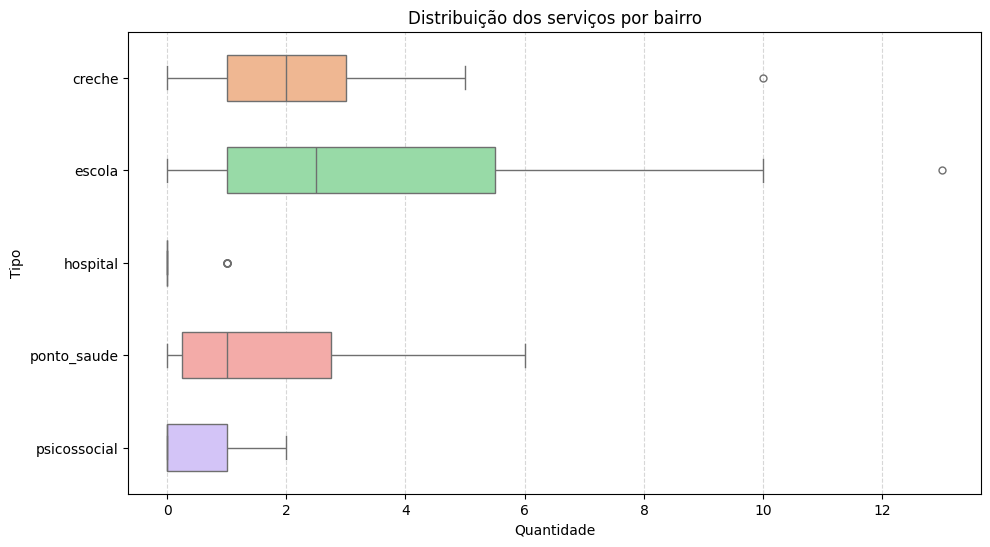

In [ ]:
long_df = all_service_counts_df \
  .reset_index() \
  .melt(
    id_vars='neighborhood_name',
    var_name='service',
    value_name='count'
  )

service_order = sorted(long_df['service'].unique())

plt.figure(figsize=(11, 6))

# distribution
sns.boxplot(
  data=long_df,
  x='count',
  y='service',
  order=service_order,
  hue='service',
  palette='pastel',
  legend=False,
  showcaps=True,
  width=0.5,
  fliersize=5
)

plt.title('Distribuição dos serviços por bairro')

plt.xlabel('Quantidade')
plt.ylabel('Tipo')

plt.grid(axis='x', linestyle='dashed', alpha=0.5)

plt.show()

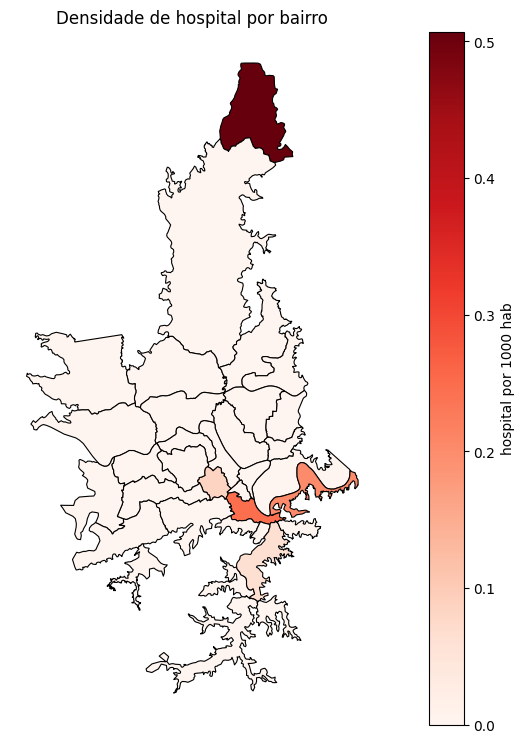

In [ ]:
def make_density_heat_map(target_service: str):
  service_density = all_service_counts_df \
    .join(neighborhoods.set_index('name')[['hab']]) \
    .fillna(0)

  for col in ALL_SERVICE_TAGS:
    service_density[col + '_por_1000'] = (service_density[col] / service_density['hab']) * 1000

  neighborhoods_density = neighborhoods.set_index('name') \
    .join(service_density, lsuffix='_geo', rsuffix='_dens')

  fig, ax = plt.subplots(figsize=(14, 9))

  neighborhoods_density.plot(
    column=f'{target_service}_por_1000',
    cmap='Reds',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': f'{target_service} por 1000 hab'},
    ax=ax
  )

  plt.title(f'Densidade de {target_service} por bairro')
  plt.axis('off')
  plt.show()

make_density_heat_map(HOSPITAL_TAG)

3. Caminhos mais curtos

In [ ]:
def make_path_map(student_name: str, target_service: str, graph: nx.MultiDiGraph = G):
  origin_node = get_student_node_id(student_name)

  dest_node = closest_service_from_student(student_name, target_service)

  path = nx.shortest_path(graph, origin_node, dest_node, weight='length')

  path_coords = [get_node_location(G.nodes[n]) for n in path]

  m = make_map(G)

  fl.PolyLine(
    locations=path_coords,
    color='red',
    weight=5,
    opacity=1,
    tooltip=f'Caminho até {target_service}'
  ).add_to(m)

  return m

make_path_map('lemuel', HOSPITAL_TAG)

# Conclusão

A cidade conta com um número de hospitais bastante reduzido em relação à sua população. Dentre os existentes, apenas três possuem convênio com o SUS. O Hospital Misericórdia atende exclusivamente as regiões da Itoupava Central e Vila Itoupava (visto que o custo de deslocamento da região Central da cidade para o norte, onde está o Hospital Misericórdia, não faz sentido havendo outros dois mais ao sul), enquanto os hospitais Santa Isabel (bairro Centro) e Santo Antônio (no bairro Vorstadt) são responsáveis por atender os demais bairros. Ressalta-se que esses dois últimos estão localizados na porção sul do município, a menos de 1 km de distância um do outro, o que evidencia não apenas uma distribuição geográfica pouco equilibrada. Neste cenário, é evidente que é essencial a existencia de mais unidades hospitalares e melhor distribuição geográfica e, para equilibrar, é necessário no mínimo mais um hospital na região lesta da cidade. Como sugestão no bairro Água Verde, área que faz divisa com Velha, Salto Weissbach, Escola Agrícola e Vila Nova.